In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


### Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
    - For categorical features, replace them with 'NA'
    - For numerical features, replace with with 0.0


In [71]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [72]:
categorical = df.dtypes[df.dtypes == object].index.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [73]:
numerical = list(set(df.columns) - set(categorical))

In [74]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna("NaN")

In [75]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Question 1

**What is the most frequent observation (mode) for the column industry?**

- NA
- technology
- healthcare
- retail

In [76]:
df["industry"].mode()

0    retail
Name: industry, dtype: object

In [77]:
df["industry"].value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NaN              134
Name: count, dtype: int64

### Question 2

- Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

**What are the two features that have the biggest correlation?**

- interaction_count and lead_score
- number_of_courses_viewed and lead_score
- number_of_courses_viewed and interaction_count
- annual_income and interaction_count
- Only consider the pairs above when answering this question.

In [78]:
corr_matrix = df.corr(numeric_only=True)  
print(corr_matrix)

                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   
converted                                 0.435914       0.053131   

                          interaction_count  lead_score  converted  
number_of_courses_viewed          -0.023565   -0.004879   0.435914  
annual_income                      0.027036    0.015610   0.053131  
interaction_count                  1.000000    0.009888   0.374573  
lead_score                         0.009888    1.000000   0.193673  
converted                          0.374573    0.193673   1.000000  


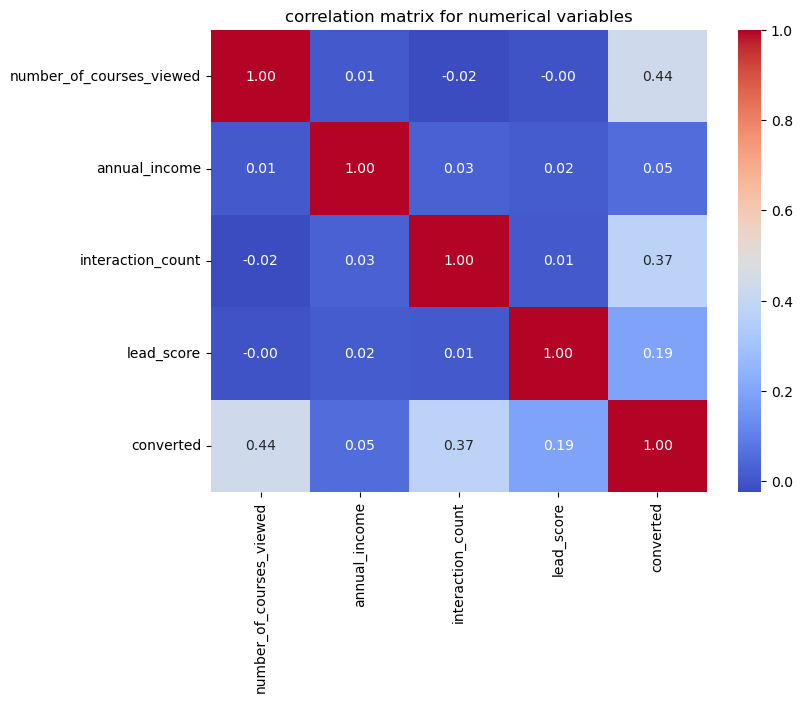

In [79]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("correlation matrix for numerical variables")
plt.show()

- annual_income and interaction_count's correlation with 0.03 is the biggest correlation according to pairs considered.


### Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value converted is not in your dataframe.


In [80]:
from sklearn.model_selection import train_test_split

In [81]:
full_train_df,test_df = train_test_split(df,test_size=0.2,random_state=42)
train_df,val_df = train_test_split(full_train_df,test_size=0.25,random_state=42)

In [82]:
len(full_train_df),len(train_df),len(test_df),len(val_df)

(1169, 876, 293, 293)

In [83]:
train_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop=True, inplace = True)
full_train_df.reset_index(drop=True,inplace=True)

In [84]:
y_train = train_df.converted.values
y_val = val_df.converted.values
y_test = test_df.converted.values
y_full_train = full_train_df.converted.values

In [85]:
del train_df["converted"]
del val_df["converted"]
del test_df["converted"]
del full_train_df["converted"]




### Question 3

- Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).
- Which of these variables has the biggest mutual information score?

    - industry
    - location
    - lead_source
    - employment_status

In [86]:
from sklearn.metrics import mutual_info_score

In [87]:
for col in categorical:
    print(col)
    print(mutual_info_score(train_df[col],y_train))
    print()

lead_source
0.03539624379726594

industry
0.011574521435657112

employment_status
0.012937677269442782

location
0.004464157884038034



### Question 4

**Now let's train a logistic regression.**
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

**What accuracy did you get?**

- 0.64
- 0.74
- 0.84
- 0.94

In [88]:
from sklearn.feature_extraction import DictVectorizer

In [89]:
train_dict = train_df.to_dict(orient= "records")
train_dict[0]

{'lead_source': 'paid_ads',
 'industry': 'retail',
 'number_of_courses_viewed': 0,
 'annual_income': 58472.0,
 'employment_status': 'student',
 'location': 'middle_east',
 'interaction_count': 5,
 'lead_score': 0.03}

In [90]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_train.shape

(876, 31)

In [91]:
from sklearn.linear_model import LogisticRegression

In [92]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [93]:
val_dict = val_df.to_dict(orient= "records")
X_val = dv.transform(val_dict)


In [94]:

y_pred = model.predict_proba(X_val)[:,1]
y_pred.shape

(293,)

In [95]:
converted_pred = y_pred >= 0.5

In [97]:
round((converted_pred == y_val).mean(),2)

np.float64(0.7)

### Question 5

**Let's find the least useful feature using the feature elimination technique.**

- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

**Which of following feature has the smallest difference?**

- 'industry'
- 'employment_status'
- 'lead_score'

Note: The difference doesn't have to be positive.

In [ ]:
col_to_del = ['industry','employment_status','lead_score']
results= {}
for col in col_to_del:
    # Columns keeped for accuracy test
    current_cols = [c for c in train_df.columns if c != col]
    # Transformn train dataset in dictionary
    train_dict_c = train_df[current_cols].to_dict(orient= "records")
    # Create an DictVectorizer object for one-hot encoding
    dv = DictVectorizer(sparse=False)
    # Fit and transform our data
    X_train_c = dv.fit_transform(train_dict_c)
    # Transformn validation dataset in dictionary
    val_dict_c = val_df[current_cols].to_dict(orient= "records")
    # Transform validation dataset with the same features than X_train
    X_val_c = dv.transform(val_dict_c)
    # Create a regLog model with parameters & regularization C=1
    model_c = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    # Train the model
    model_c.fit(X_train_c,y_train)
    # Get back the probas for our target with "1"
    y_pred_c = model_c.predict_proba(X_val_c)[:,1]
    # Create an array where All values superior or equal to 0.5 will be True
    converted_pred_c = y_pred_c >= 0.5
    # Accuracy comparing to y_val
    accuracy_c = (converted_pred_c == y_val).mean()
    # Difference between original accuracy and accuracy with feature elimination
    difference = accuracy - accuracy_c
    # Storing the results in a dictionary
    results[col] = {'accuracy': accuracy_c, 'diff_vs_baseline': difference}

print(results)


{'industry': {'accuracy': np.float64(0.6996587030716723), 'diff_vs_baseline': np.float64(0.0)}, 'employment_status': {'accuracy': np.float64(0.6962457337883959), 'diff_vs_baseline': np.float64(0.0034129692832763903)}, 'lead_score': {'accuracy': np.float64(0.7064846416382252), 'diff_vs_baseline': np.float64(-0.0068259385665528916)}}


In [111]:
min_key = min(results, key=lambda k: abs(results[k]['diff_vs_baseline']))
print(f"Column : {min_key}")
print(f"Minimal absolute diff : {results[min_key]['diff_vs_baseline']}")

Column : industry
Minimal absolute diff : 0.0


### Question 6

**Now let's train a regularized logistic regression.**

- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.
- Which of these C leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100

**Note: If there are multiple options, select the smallest C.**

In [114]:
X_train

array([[5.8472e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.1738e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        3.0000e+00],
       [8.1973e+04, 0.0000e+00, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        3.0000e+00],
       ...,
       [8.9042e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        3.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [5.0259e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.0000e+00]], shape=(876, 31))

In [126]:
C_reg = [0.01, 0.1, 1, 10, 100]
results= {}

for C in C_reg:

  
    # Create a regLog model with parameters & regularization fine-tuned
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    # Train the model
    model.fit(X_train,y_train)
    # Get back the probas for our target with "1"
    y_pred = model.predict_proba(X_val)[:,1]
    # Create an array where All values superior or equal to 0.5 will be True
    converted_pred = y_pred >= 0.5
    # Accuracy comparing to y_val
    accuracy = (converted_pred == y_val).mean()
    
    results[C] = {'accuracy': accuracy}

print(results)

{0.01: {'accuracy': np.float64(0.6996587030716723)}, 0.1: {'accuracy': np.float64(0.6996587030716723)}, 1: {'accuracy': np.float64(0.6996587030716723)}, 10: {'accuracy': np.float64(0.6996587030716723)}, 100: {'accuracy': np.float64(0.6996587030716723)}}


In [127]:
max_key = max(results, key=lambda k: results[k]['accuracy'])
print(f"C-Regularization: {max_key}")
print(f"Max accuracy : {results[max_key]['accuracy']}")

C-Regularization: 0.01
Max accuracy : 0.6996587030716723
